In [1]:
import sys 
import os
sys.path.append(os.path.join(os.path.split(sys.path[0])[0], 'src'))

import numpy as np
a = np.ones((2,2))
a@a
import matplotlib.pyplot as plt

import KPCA
from KPCA import compute_kernel_matrix
from utils import get_data, calc_energy

In [ ]:
def reverse_combo(base, extra,combo, X, theta, eps = None, dx = 1, dy = None):
    K1 = compute_kernel_matrix(X, base.X_fit, base.kernel, theta, eps,dx,dy)
    K2 = compute_kernel_matrix(X, extra.X_fit, extra.kernel, theta, eps,dx,dy)

    K = K1 * K2
    mean = combo.K_fit.mean(0)[None,:]
    Phi = (K - mean) @ combo.U_fit

    sqrt_theta = np.sqrt(theta).T
    ones_phi = np.ones((Phi.shape[0],1))
    Phi_ext = np.concatenate([ones_phi] + [ones_phi / sqrt_theta] + [Phi**(k+1) for k in range(combo.degree)]+ [(Phi / sqrt_theta)**(k+1) for k in range(combo.degree)], axis=1)
    #reconstruction
    X = combo.R@Phi_ext.T
    return X

In [2]:
model_base = KPCA.KernelPCA()
model_prod = KPCA.KernelPCA()
model_final = KPCA.KernelPCA()
model_pca = KPCA.KernelPCA()

In [3]:
dx = .0125
Re = 0.001
Wi = 5
beta = 0.5
X, Xmean = get_data(Re, Wi, beta, case='cavity_ref', n_data = 200,dir_path='../../npz_data', from_end=False)
theta =((1-beta)/(Re*Wi))
print('Theta: ', theta)

Theta:  100.0


In [57]:
gamma = 10
kernel = 'rbf'

model_base.fit(X.T,2,'oldroyd',theta = theta,dx=dx,center=False)
model_pca.fit(X.T,2,'linear',theta = theta,dx=1,)
model_prod.fit(X.T,2,kernel,theta = theta,dx=1,eps=gamma)

model_final.fit(X.T,2,'oldroyd',theta = theta,dx=1,)
model_final.K_fit = model_base.K_fit * model_prod.K_fit
model_final.train_R(n_components=2)

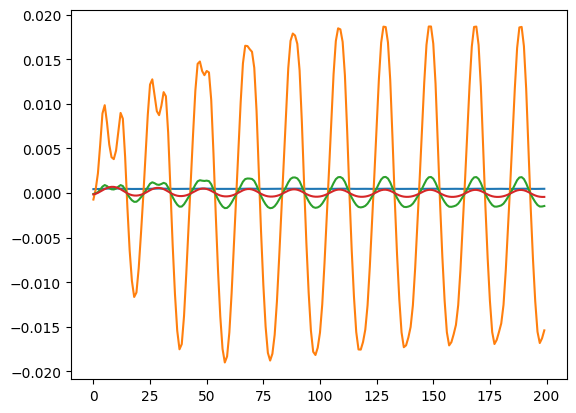

In [58]:
plt.plot(model_base.normalized_eigenvector[:,0])
plt.plot(model_prod.normalized_eigenvector[:,0])
plt.plot(model_final.normalized_eigenvector[:,0])
plt.plot(model_pca.normalized_eigenvector[:,0])

In [ ]:
X_base = model_base.invert_transform(model_base.transform(X.T,theta, dx = dx), theta)
X_prod = model_prod.invert_transform(model_prod.transform(X.T,theta, eps = gamma, dx = dx), theta)
X_combo = reverse_combo(model_base, model_prod, model_final, X.T, theta = theta, dx = dx, eps = gamma)
X_pca = model_pca.invert_transform(model_pca.transform(X.T,theta, 1), theta)

In [61]:

_,_, total = calc_energy(X, Wi, beta, Re, dx)
_,_, base = calc_energy(X_base, Wi, beta, Re, dx)
_,_, prod = calc_energy(X_prod, Wi, beta, Re, dx)
_,_, combo = calc_energy(X_combo, Wi, beta, Re, dx)
_,_, pca = calc_energy(X_pca, Wi, beta, Re, dx)

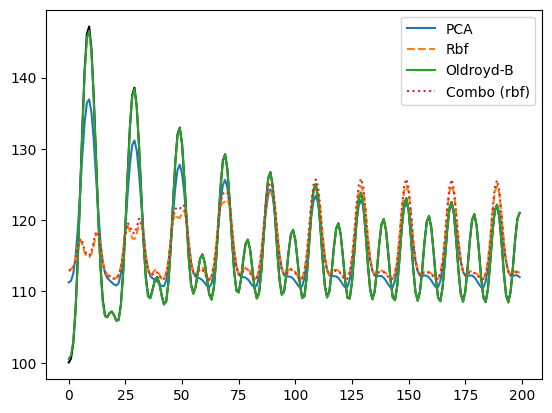

In [62]:
plt.plot(total,'k')
plt.plot(pca, label = 'PCA')
plt.plot(prod,'--', label = f'{kernel.capitalize()}')
plt.plot(base, label = 'Oldroyd-B')
plt.plot(combo,linestyle='dotted', label = f'Combo ({kernel})')

plt.legend()

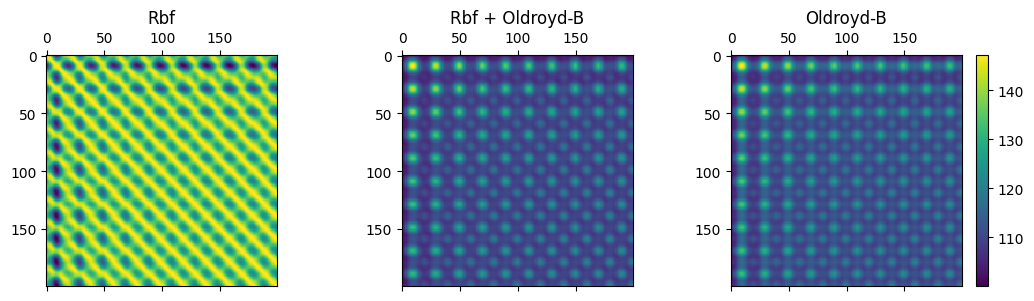

In [50]:
gamma = 200
kernel = 'rbf'
model_base.fit(X.T,2,'oldroyd',theta = theta,dx=dx,)
model_pca.fit(X.T,2,'linear',theta = theta,dx=1,)
model_prod.fit(X.T,2,kernel,theta = theta,dx=1,eps=gamma)

model_final.fit(X.T,2,'oldroyd',theta = theta,dx=1,)
model_final.K_fit = model_base.K_fit * model_prod.K_fit
model_final.train_R(n_components=2)

f, ax = plt.subplots(figsize=(13, 3), ncols=3)
ax[0].matshow(model_prod.K_fit)
ax[1].matshow(model_final.K_fit)
s = ax[2].matshow(model_base.K_fit)


ax[0].set_title(f'{kernel.capitalize()}')
ax[1].set_title(f'{kernel.capitalize()} + Oldroyd-B')
ax[2].set_title('Oldroyd-B')
f.colorbar(s, ax = ax[2])

In [17]:
model_dx = KPCA.KernelPCA()
model_one = KPCA.KernelPCA()

model_dx.fit(X.T,2,'oldroyd',theta = theta,dx=dx, center = False)
model_one.fit(X.T,2,'oldroyd',theta = theta,dx=1, center = False)

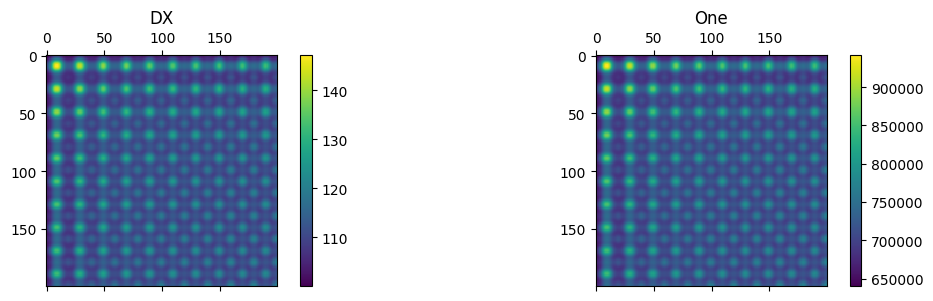

In [18]:
f, ax = plt.subplots(figsize=(13, 3), ncols=2)
sx = ax[0].matshow(model_dx.K_fit)
s1 = ax[1].matshow(model_one.K_fit)


ax[0].set_title(f'DX')
ax[1].set_title(f'One')
f.colorbar(sx, ax = ax[0])
f.colorbar(s1, ax = ax[1])

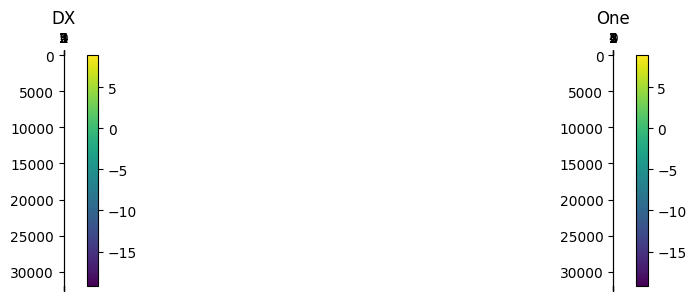

In [19]:
f, ax = plt.subplots(figsize=(13, 3), ncols=2)
sx = ax[0].matshow(model_dx.R)
s1 = ax[1].matshow(model_one.R)


ax[0].set_title(f'DX')
ax[1].set_title(f'One')
f.colorbar(sx, ax = ax[0])
f.colorbar(s1, ax = ax[1])

(200, 2)
(200, 2)


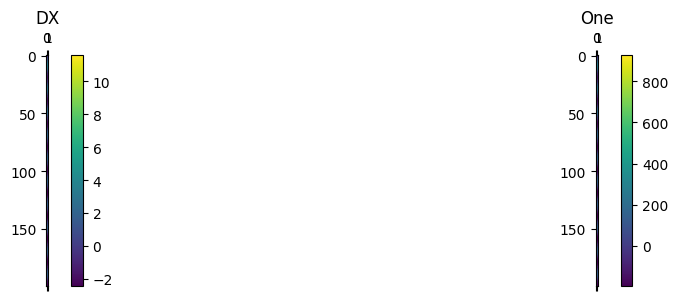

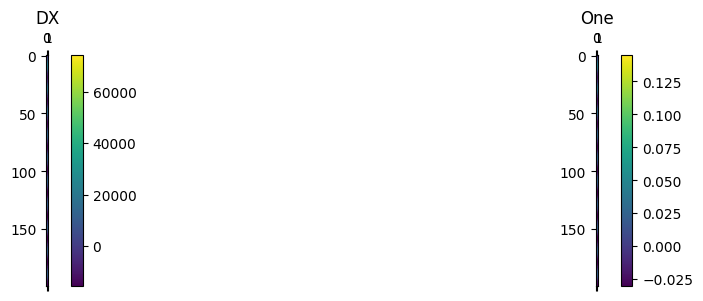

In [20]:
Phi_dx_dx = model_dx.transform(X.T,theta, dx=dx)
Phi_1_1 = model_one.transform(X.T,theta, dx=1)

f, ax = plt.subplots(figsize=(13, 3), ncols=2)
sx = ax[0].matshow(Phi_dx_dx)
s1 = ax[1].matshow(Phi_1_1)


ax[0].set_title(f'DX')
ax[1].set_title(f'One')
f.colorbar(sx, ax = ax[0])
f.colorbar(s1, ax = ax[1])


Phi_dx_1 = model_dx.transform(X.T,theta, dx=1)
Phi_1_dx = model_one.transform(X.T,theta, dx=dx)

f, ax = plt.subplots(figsize=(13, 3), ncols=2)
sx = ax[0].matshow(Phi_dx_1)
s1 = ax[1].matshow(Phi_1_dx)


ax[0].set_title(f'DX')
ax[1].set_title(f'One')
f.colorbar(sx, ax = ax[0])
f.colorbar(s1, ax = ax[1])

print(Phi_dx_dx.shape)
print(Phi_1_1.shape)

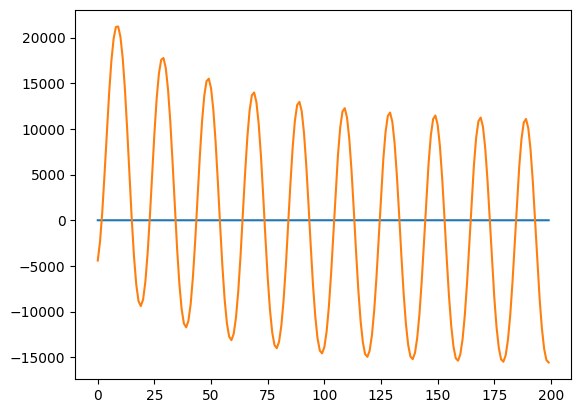

In [21]:
plt.plot(Phi_dx_dx[:,1])
plt.plot(Phi_dx_1[:,1])

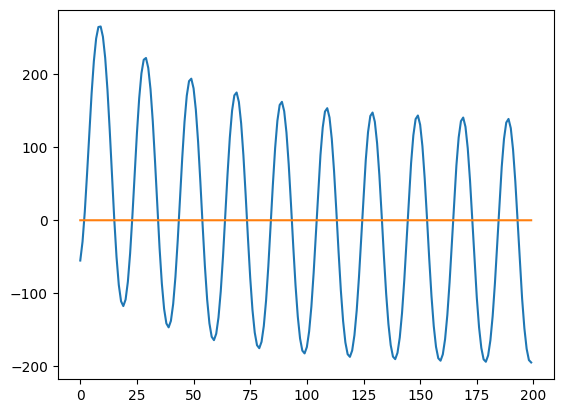

In [22]:
plt.plot(Phi_1_1[:,1])
plt.plot(Phi_1_dx[:,1])

In [23]:
X_dx = model_dx.invert_transform(Phi_dx_dx, theta)
X_one = model_one.invert_transform(Phi_1_1, theta)

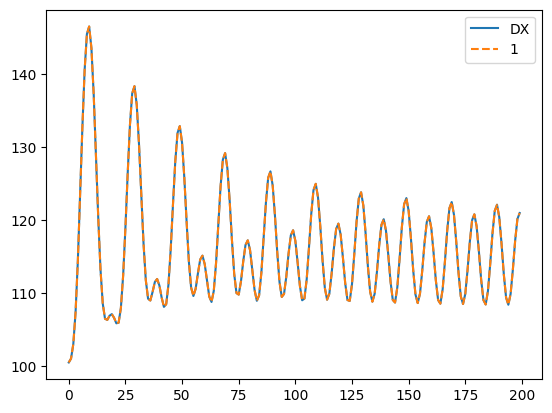

In [25]:
_,_, energy_dx = calc_energy(X_dx, Wi, beta, Re, dx)
_,_, energy_one = calc_energy(X_one, Wi, beta, Re, dx)


plt.plot(energy_dx, label = 'DX')
plt.plot(energy_one, '--',label = '1')
plt.legend()